In [1]:
import torch
import torchvision
import torchvision.transforms.v2 as T
from torch.utils.data import DataLoader, Dataset

import jax
import jax.numpy as jnp
from jax import random

# neural networks
import flax
from flax import linen as nn
from flax.training import train_state

# optimizer
import optax

import numpy as np
import matplotlib.pyplot as plt

print(f"running on {jax.devices()}")

running on [CudaDevice(id=0)]


In [2]:
transforms = T.Compose([
    T.ToImage(),
    T.ToDtype(torch.float32)
])

train_dataset = torchvision.datasets.MNIST("mnist_train", train=True, download=True, transform=transforms)
val_dataset = torchvision.datasets.MNIST("mnist_val", train=False, download=True, transform=transforms)


100%|██████████| 9.91M/9.91M [00:02<00:00, 4.85MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 129kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.22MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.7MB/s]
100%|██████████| 9.91M/9.91M [00:02<00:00, 4.80MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 129kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.23MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.90MB/s]


In [4]:
def numpy_collate(batch):
  if isinstance(batch[0], np.ndarray):
    return np.stack(batch)
  elif isinstance(batch[0], (tuple, list)):
    transposed = zip(*batch)
    return [numpy_collate(samples) for samples in transposed]
  else:
      return np.array(batch)


batch_size=128
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=numpy_collate)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=numpy_collate)

images, labels = next(iter(train_dataloader))

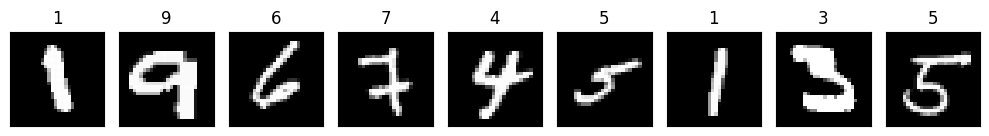

In [5]:
#visualize data
samples = torch.randperm(len(images))[:9]

fig, axs = plt.subplots(nrows=1, ncols=9, figsize=(10,5))
for i, sample in enumerate(samples):
  axs[i].imshow(images[sample].reshape(28,28, 1), cmap='gray')
  axs[i].set_xticks([])
  axs[i].set_yticks([])
  axs[i].set_title(labels[sample])

plt.tight_layout()
plt.show()

In [31]:
## define jax model
class MnistClassifier(nn.Module):
  num_hidden_dims: int
  num_classes:int = 10

  @nn.compact
  def __call__(self, x):
    # flatten
    batch_size = x.shape[0]
    x = x.reshape(batch_size, -1)

    x = nn.Dense(self.num_hidden_dims)(x)
    x = nn.relu(x)
    x = nn.Dense(self.num_classes)(x)
    return x

model = MnistClassifier(num_hidden_dims=256)
print(model)

MnistClassifier(
    # attributes
    num_hidden_dims = 256
    num_classes = 10
)


In [32]:
rng = random.PRNGKey(42)

## initialize parameters
rng, init_rng, inp_rng = random.split(rng, num=3)
inp = random.normal(inp_rng, (batch_size, 784))

# initialize the model
params = model.init(init_rng, inp)
print(params)

{'params': {'Dense_0': {'kernel': Array([[ 0.00146282,  0.0303744 , -0.00189085, ...,  0.02345678,
        -0.03333088, -0.01636083],
       [-0.01393382,  0.03463469,  0.06681239, ..., -0.00560017,
         0.01976231, -0.06124127],
       [-0.03752617, -0.0224647 , -0.00358839, ...,  0.00973418,
         0.00061298, -0.00322319],
       ...,
       [-0.02327318, -0.03249559,  0.02932177, ...,  0.03000786,
         0.003197  ,  0.04119755],
       [-0.00132557, -0.064254  ,  0.02933339, ..., -0.04602396,
        -0.00305788,  0.0098564 ],
       [-0.03728857, -0.00804343,  0.03514292, ..., -0.02301928,
         0.02517841, -0.01707928]], dtype=float32), 'bias': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.

In [33]:
# test model on dummy input
model.apply(params, inp).shape

(128, 10)

In [63]:
# setup optimizer
optimizer = optax.adam(learning_rate=1e-3)

In [64]:
model_state = train_state.TrainState.create(apply_fn=model.apply,
                                     params=params,
                                     tx=optimizer)

In [65]:
logits = model_state.apply_fn(params, inp)
logits

Array([[ 0.968806  ,  0.0435088 , -0.12907754, ...,  0.4769447 ,
         0.71310383,  0.8845619 ],
       [ 0.0481286 ,  0.4423038 , -0.94077766, ...,  0.17891175,
         0.50131774,  1.0600162 ],
       [-0.6224095 ,  0.3853703 ,  0.3957398 , ..., -0.05496946,
        -0.67417884,  1.0087101 ],
       ...,
       [-0.5896615 ,  0.5856403 , -0.71087134, ...,  0.41536897,
         0.28236067, -0.02581911],
       [-0.16045502, -0.52474856, -0.9455726 , ..., -0.6519515 ,
        -0.9433311 , -0.51425636],
       [ 0.56433153,  0.6647259 ,  0.04093841, ...,  0.339611  ,
        -0.5102291 ,  0.34984   ]], dtype=float32)

In [66]:
logits.shape

(128, 10)

In [67]:
def calculate_loss_accuracy(state, params, batch):
  images, labels = batch

  logits = state.apply_fn(params, images)

  # calculate loss and accuracy
  loss = optax.softmax_cross_entropy_with_integer_labels(logits, labels).mean()
  acc = (labels == jnp.argmax(logits, axis=1)).mean()

  return loss, acc

In [68]:
batch = next(iter(train_dataloader))
calculate_loss_accuracy(model_state, model_state.params, batch)

(Array(87.03523, dtype=float32), Array(0.0625, dtype=float32))

In [69]:
# training
@jax.jit
def train_step(state, batch):
  # gradient function
  grad_fn = jax.value_and_grad(calculate_loss_accuracy,
                               argnums=1,
                               has_aux=True
                               )
  # determine gradients for current step
  (loss, acc), grads = grad_fn(state, state.params, batch)

  # update parameters
  state = state.apply_gradients(grads=grads)

  return state, loss, acc

In [70]:
# for model evaluation

@jax.jit
def eval_step(state, batch):
  # we dont need loss
  _, acc = calculate_loss_accuracy(state, state.params, batch)
  return acc

In [75]:
# train the model
def train_model(state, dataloader, val_dataloader, epochs):
  for epoch in range(epochs):
    for batch in dataloader:
      state, loss, acc = train_step(state, batch)

    for batch in val_dataloader:
      val_acc = eval_step(state, batch)

    print(f"{epoch+1}/{epochs} | loss: {loss:.4f} | train_acc: {acc:.4f} | val_acc: {val_acc:.4f}")
  return state

In [76]:
trained_model_state = train_model(model_state, train_dataloader, val_dataloader, epochs=10)

1/10 | loss: 0.5670 | train_acc: 0.8958 | val_acc: 0.8750
2/10 | loss: 0.1653 | train_acc: 0.9271 | val_acc: 1.0000
3/10 | loss: 0.0919 | train_acc: 0.9792 | val_acc: 1.0000
4/10 | loss: 0.1099 | train_acc: 0.9688 | val_acc: 1.0000
5/10 | loss: 0.0597 | train_acc: 0.9792 | val_acc: 1.0000
6/10 | loss: 0.1292 | train_acc: 0.9688 | val_acc: 0.9375
7/10 | loss: 0.1630 | train_acc: 0.9583 | val_acc: 1.0000
8/10 | loss: 0.1061 | train_acc: 0.9688 | val_acc: 1.0000
9/10 | loss: 0.1486 | train_acc: 0.9479 | val_acc: 0.9375
10/10 | loss: 0.0604 | train_acc: 0.9896 | val_acc: 1.0000
